        Date      imf1      imf2      imf3      imf4      imf5      imf6      imf7      imf8      imf9      imf10
0 1986-01-02 -0.327365  0.173387 -0.625464  2.416827  3.584146  3.518510 -1.362703  1.056863 -1.262136  18.387935
1 1986-01-03 -0.084845  0.325226 -0.645562  2.509058  3.597476  3.496085 -1.382060  1.060703 -1.263064  18.386984
2 1986-01-06  0.319082  0.365278 -0.535123  2.531153  3.594384  3.470034 -1.401384  1.064524 -1.263981  18.386034
3 1986-01-07 -0.310130  0.182301 -0.290603  2.485214  3.574936  3.440430 -1.420674  1.068328 -1.264886  18.385085
4 1986-01-08 -0.098686 -0.124846  0.021339  2.374503  3.539778  3.407369 -1.439928  1.072113 -1.265779  18.384137


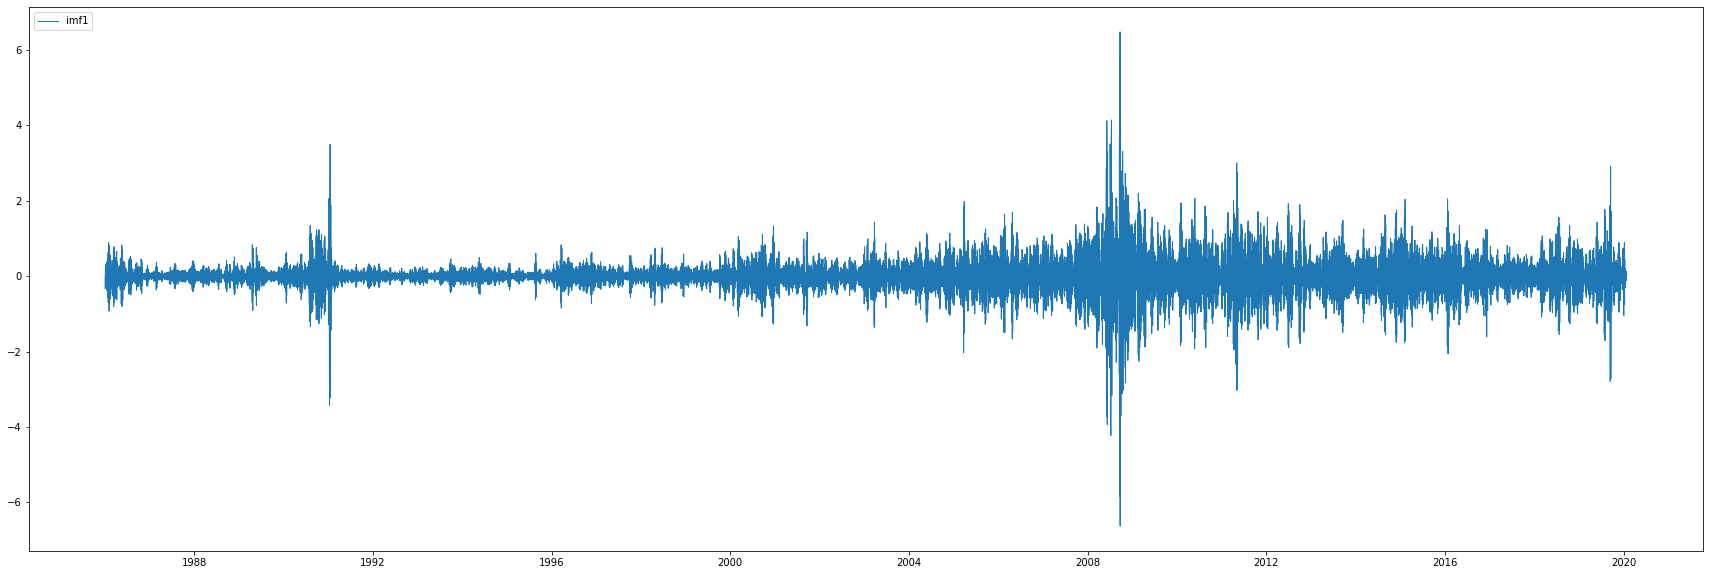

In [4]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from math import sqrt
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt   # Import matplotlib
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU

data=pd.read_excel(r'F:\研究生阶段\毕业设计\处理数据\EMD分解.xls')
'''
先对imf1进行预测
'''
print(data.head())

data1=data[['Date','imf1']].set_index('Date')
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(data1.index,data1,linestyle='-',linewidth=1,label='imf1')
# plt.plot(data1['Date'],data1['WTI-Spot-Price'],linestyle='-',linewidth=1,label='WTI-Spot-Price')
plt.legend(loc='upper left')

In [5]:
'''
最大最小归一化数据
'''
from sklearn.preprocessing import MinMaxScaler
x_train=data1['1986-1-2':'2008-3-31'].values
x_test=data1['2008-4-1':'2013-10-21'].values
min_max_scaler=MinMaxScaler()
x_train_scale=min_max_scaler.fit_transform(x_train)
x_test_scale=min_max_scaler.transform(data1['2008-4-1':'2013-10-21'])
print(x_test_scale)
print(x_train_scale)

[[0.2845033 ]
 [0.69930825]
 [0.30714689]
 ...
 [0.40938884]
 [0.58579739]
 [0.53284672]]
[[0.44784495]
 [0.48288162]
 [0.54123665]
 ...
 [0.68567467]
 [0.59538552]
 [0.28679941]]


In [6]:
def build_timeseries(mat, y_col_index, TIME_STEPS,LEADING_DAYS):
    # y_col_index 是作为输出列的列号
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS-LEADING_DAYS #number of time-series samples 
    dim_1 = mat.shape[1]# number of features
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(0,dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+LEADING_DAYS+i, y_col_index]#‘y_col_index’ is the index of your output column
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [7]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size 
    #here the input 'mat' should be the overall input time series data which has already been devided into windows 
    #这里的mat应该是已经被划分时间窗口的总体的时间序列数据
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [8]:
BATCH_SIZE=10
TIME_STEPS=1
LEADING_DAYS=0
epoch=50
x_t, y_t = build_timeseries(x_train_scale,0, TIME_STEPS, LEADING_DAYS)#data for train
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test_scale,0,TIME_STEPS, LEADING_DAYS)# x_temp contains the data for validation as well as for test
x_test=trim_dataset(x_temp, BATCH_SIZE)
y_test=trim_dataset(y_temp, BATCH_SIZE)

length of time-series i/o (5611, 1, 1) (5611,)
length of time-series i/o (1402, 1, 1) (1402,)


In [9]:
from keras import optimizers
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
OUTPUT_PATH="F:\\研究生阶段\\机器学习\\深度学习\\LSTM实现"
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_test, BATCH_SIZE),trim_dataset(y_test, BATCH_SIZE)), callbacks=[csv_logger])

Train on 5610 samples, validate on 1400 samples
Epoch 1/50
 - 2s - loss: 0.0161 - val_loss: 0.0235
Epoch 2/50
 - 2s - loss: 0.0042 - val_loss: 0.0227
Epoch 3/50
 - 2s - loss: 0.0036 - val_loss: 0.0223
Epoch 4/50
 - 1s - loss: 0.0032 - val_loss: 0.0220
Epoch 5/50
 - 1s - loss: 0.0031 - val_loss: 0.0220
Epoch 6/50
 - 2s - loss: 0.0030 - val_loss: 0.0219
Epoch 7/50
 - 2s - loss: 0.0030 - val_loss: 0.0217
Epoch 8/50
 - 1s - loss: 0.0030 - val_loss: 0.0217
Epoch 9/50
 - 1s - loss: 0.0030 - val_loss: 0.0216
Epoch 10/50
 - 1s - loss: 0.0030 - val_loss: 0.0216
Epoch 11/50
 - 2s - loss: 0.0030 - val_loss: 0.0217
Epoch 12/50
 - 1s - loss: 0.0030 - val_loss: 0.0217
Epoch 13/50
 - 1s - loss: 0.0030 - val_loss: 0.0217
Epoch 14/50
 - 1s - loss: 0.0030 - val_loss: 0.0217
Epoch 15/50
 - 2s - loss: 0.0030 - val_loss: 0.0217
Epoch 16/50
 - 2s - loss: 0.0030 - val_loss: 0.0219
Epoch 17/50
 - 1s - loss: 0.0030 - val_loss: 0.0217
Epoch 18/50
 - 1s - loss: 0.0029 - val_loss: 0.0217
Epoch 19/50
 - 1s - loss:

RMSE 1.0810035070364747


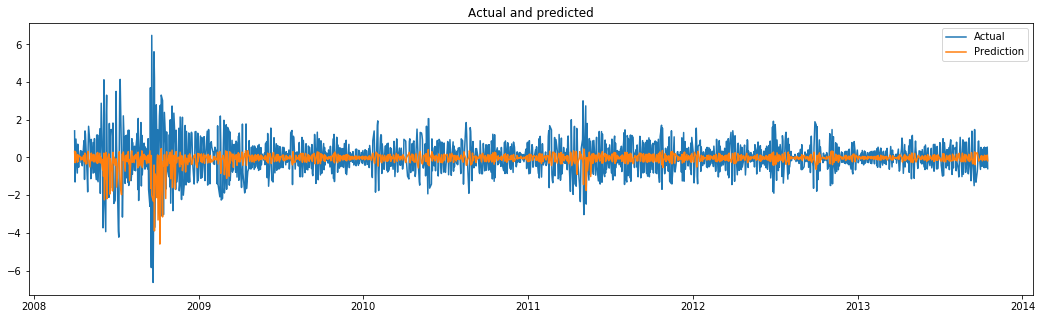

In [14]:
from sklearn.metrics import mean_squared_error
pred = lstm_model.predict(trim_dataset(x_test,BATCH_SIZE), batch_size=BATCH_SIZE)
predicted = pred
Date_test=trim_dataset(data1['2008-4-1':'2013-10-21'].index,BATCH_SIZE)
Date_test=pd.to_datetime(Date_test.date)[-len(pred):]
original = trim_dataset(y_test,BATCH_SIZE)
invert_pred=min_max_scaler.inverse_transform(pred)
pre_data=pd.DataFrame(invert_pred,index=Date_test,columns=['pre-imf1'])
pre_data.to_excel(r'F:\研究生阶段\毕业设计\处理数据\pred_imf1.xls')
original=min_max_scaler.inverse_transform(original.reshape(-1,1))
error = mean_squared_error(original, invert_pred)**0.5
print("RMSE", error)
plt.figure(figsize=(18,5))
plt.title('Actual and predicted')
plt.plot(Date_test,original, label = 'Original data')
plt.plot(Date_test,invert_pred, label = 'Predicted data')
plt.legend(['Actual', 'Prediction'],loc='best')
plt.show()